In [29]:
import numpy as np
import matplotlib.pyplot as plt
import smote_variants as sv
import imbalanced_databases as imbd
import pandas as pd
import time
import logging

from collections import Counter


from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import recall_score, roc_auc_score, f1_score, brier_score_loss, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import preprocessing


le = preprocessing.LabelEncoder()
random_state=4

In [30]:
_logger = logging.getLogger('smote_variants')
_logger.setLevel(logging.DEBUG)
_logger_ch = logging.StreamHandler()
_logger_ch.setFormatter(logging.Formatter(
    "%(asctime)s:%(levelname)s:%(message)s"))
_logger.addHandler(_logger_ch)

In [31]:
class synthsonic(sv.OverSampling) :
    
    def __init__(self,
                 proportion=1.0,
                 distinct_threshold=-1,
                 n_jobs=1, 
                 random_state=None) :
        
        
        super().__init__()
        
        self.check_greater_or_equal(proportion, "proportion", 0)
        self.check_n_jobs(n_jobs, 'n_jobs')

        self.proportion = proportion
        self.distinct_threshold = distinct_threshold
        self.n_jobs = n_jobs

        self.set_random_state(random_state)
        
        
    @classmethod
    def parameter_combinations(cls, raw=False) :
        
        parameter_combinations = {'proportion': [0.1, 0.25, 0.5, 0.75,
                                                 1.0, 1.5, 2.0]}
        
        return cls.generate_parameter_combinations(parameter_combinations, raw)
    
    def sample(self, X, y) :
        
        _logger.info(self.__class__.__name__ + ": " +
                     "Running sampling via %s" % self.descriptor())
        
        # Find minority class
        # self.find_minority(X,y)
        self.class_label_statistics(X, y)
        
        self.X_min = X[y == self.min_label]
        
        print(f"minority class {self.min_label}, min dataset {self.X_min.shape}")
        
        # fit model
        kde = KDECopulaNNPdf(distinct_threshold=self.distinct_threshold,
                             random_state=random_state)
        kde = kde.fit(self.X_min)
        
        # determine n_samples
        self.n_to_sample = self.det_n_to_sample(self.proportion,
                                           self.class_stats[self.maj_label],
                                           self.class_stats[self.min_label])

        
        # sample
        x1 = kde.sample_no_weights(n_samples=self.n_to_sample, mode='cheap')
        
        X_samp = np.vstack([X,x1])
        y_samp = np.hstack([y, [self.min_label]*self.n_to_sample])
        
        return X_samp, y_samp

    def get_params(self) :
        return {'proportion': self.proportion, 
                'n_jobs': self.n_jobs,
                'distinct_threshold':self.distinct_threshold,
                'random_state': self.random_state}
    


def writetodict(dataset,name) :
    
    data = dataset.iloc[:,:-1].values
    target = dataset.iloc[:,-1].values

    return {'data':data,
            'target':target,
            'name':name}
    
def plotter(X,y,title) :
    
    counter = Counter(y)
    
    for label, _ in counter.items() :
        rowix = np.where(y == label)[0]
        plt.scatter(X[rowix, 0], X[rowix, 1], label=str(label))
    plt.legend()
    plt.title(title)
    plt.show()

    print(counter)
    
def plot_oversampling(X,y, oversamplers) :
    
    for o in oversamplers:
        oversampler= o()
        X_samp, y_samp= oversampler.sample(X, y)

        plt.figure(figsize=(12, 5))
        ax= plt.subplot(121)
        plt.scatter(X[y == 0][:,0], X[y == 0][:,1], label='majority class', c='orange', marker='o')
        plt.scatter(X[y == 1][:,0], X[y == 1][:,1], label='minority class', c='olive', marker='o')
        plt.title('original')
        plt.xlabel('coordinate 0')
        plt.ylabel('coordinate 1')
        plt.legend()

        ax= plt.subplot(122)
        plt.scatter(X_samp[y_samp == 0][:,0], X_samp[y_samp == 0][:,1], label='majority class', c='orange', marker='o')
        plt.scatter(X_samp[y_samp == 1][:,0], X_samp[y_samp == 1][:,1], label='minority class', c='olive', marker='o')
        plt.title(oversampler.__class__.__name__)
        plt.xlabel('coordinate 0')
        plt.ylabel('coordinate 1')
        plt.legend()
        plt.show()

        
def evaluate_oversamplers(datasets, oversamplers, classifier, random_state) :

    results = []

    for data in datasets :
        
        X, y, name = data['data'], data['target'], data['name']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = random_state)

        for o in oversamplers :
            
            oversampler = o(random_state=random_state)
            print(oversampler)

            t0 = time.time()
            X_s,y_s = oversampler.sample(X_train, y_train)
            t1 = time.time() - t0

            classifier.fit(X_s,y_s)
            prediction = classifier.predict(X_test)
            proba = classifier.predict_proba(X_test)[:,1]

            f_dict = {
                'dataset':name,
                'sampler': oversampler.__class__.__name__,
                'clf_score': classifier.score(X_test,y_test),
                'recall': recall_score(y_test,prediction),
                'roc_auc_score': roc_auc_score(y_test, proba),
                'f1_score': f1_score(y_test, prediction, average='binary'),
                'brier_score_loss': brier_score_loss(y_test, proba),
                'runtime': t1
            }

            results.append(f_dict)


    return results

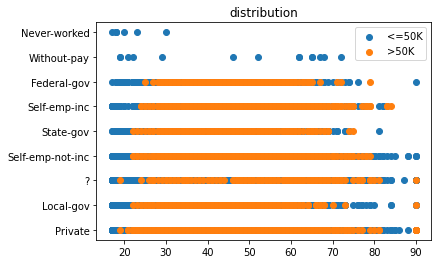

Counter({'<=50K': 24720, '>50K': 7841})


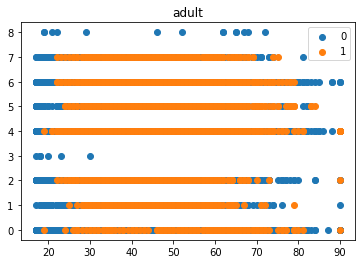

Counter({0: 24720, 1: 7841})


In [37]:
# loading datasets

path = "/Users/tristenmarto/Documents/Studie/Thesis/Synthsonic_data_analysis/Datasets/"
data = path+"adult.csv"

data = pd.read_csv(data)

plotter(data.iloc[:,:-1].values,data.iloc[:,-1].values, "distribution")

obcol = data.select_dtypes(include=['object'])

for col in obcol :
    data[col] = le.fit_transform(data[col])


data_dict = writetodict(data, 'adult')
X,y,name = data_dict['data'],data_dict['target'],data_dict['name']

plotter(X,y,name)

In [34]:
results = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = random_state)
       
oversampler = sv.NoSMOTE(random_state=random_state)
print(oversampler)

t0 = time.time()
X_s,y_s = oversampler.sample(X_train, y_train)
t1 = time.time() - t0

classifier = RandomForestClassifier(n_estimators=1000, random_state=random_state)
classifier.fit(X_s,y_s)
prediction = classifier.predict(X_test)
proba = classifier.predict_proba(X_test)[:,1]

f_dict = {
    'dataset':name,
    'sampler': oversampler.__class__.__name__,
    'clf_score': classifier.score(X_test,y_test),
    'recall': recall_score(y_test,prediction),
    'roc_auc_score': roc_auc_score(y_test, proba),
    'f1_score': f1_score(y_test, prediction, average='binary'),
    'brier_score_loss': brier_score_loss(y_test, proba),
    'runtime': t1
}

results.append(f_dict)

print(results)
print(confusion_matrix(y_test,prediction))
print(classification_report(y_test, prediction, target_names=['class0','class1']))

2021-06-03 15:17:40,073:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-06-03 15:17:40,073:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-06-03 15:17:40,073:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-06-03 15:17:40,073:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-06-03 15:17:40,073:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


('NoSMOTE', '{}')
[{'dataset': 'adult', 'sampler': 'NoSMOTE', 'clf_score': 0.8580867299460264, 'recall': 0.6323699421965318, 'roc_auc_score': 0.910626188873831, 'f1_score': 0.6827543166215935, 'brier_score_loss': 0.09795885537223153, 'runtime': 0.0058400630950927734}]
[[7580  571]
 [ 954 1641]]
              precision    recall  f1-score   support

      class0       0.89      0.93      0.91      8151
      class1       0.74      0.63      0.68      2595

    accuracy                           0.86     10746
   macro avg       0.82      0.78      0.80     10746
weighted avg       0.85      0.86      0.85     10746



In [36]:
results = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = random_state)
       
oversampler = sv.SMOTE(random_state=random_state)
print(oversampler)

t0 = time.time()
X_s,y_s = oversampler.sample(X_train, y_train)
t1 = time.time() - t0

classifier = RandomForestClassifier(n_estimators=1000, random_state=random_state)
classifier.fit(X_s,y_s)
prediction = classifier.predict(X_test)
proba = classifier.predict_proba(X_test)[:,1]

f_dict = {
    'dataset':name,
    'sampler': oversampler.__class__.__name__,
    'clf_score': classifier.score(X_test,y_test),
    'recall': recall_score(y_test,prediction),
    'roc_auc_score': roc_auc_score(y_test, proba),
    'f1_score': f1_score(y_test, prediction, average='binary'),
    'brier_score_loss': brier_score_loss(y_test, proba),
    'runtime': t1
}

results.append(f_dict)

print(results)
print(confusion_matrix(y_test,prediction))
print(classification_report(y_test, prediction, target_names=['class0','class1']))

2021-06-03 15:18:14,818:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")
2021-06-03 15:18:14,818:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")
2021-06-03 15:18:14,818:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")
2021-06-03 15:18:14,818:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")
2021-06-03 15:18:14,818:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")


('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")
[{'dataset': 'adult', 'sampler': 'SMOTE', 'clf_score': 0.8508282151498232, 'recall': 0.6581888246628131, 'roc_auc_score': 0.9052708640782873, 'f1_score': 0.6806136680613668, 'brier_score_loss': 0.10246625875871335, 'runtime': 0.08595895767211914}]
[[7435  716]
 [ 887 1708]]
              precision    recall  f1-score   support

      class0       0.89      0.91      0.90      8151
      class1       0.70      0.66      0.68      2595

    accuracy                           0.85     10746
   macro avg       0.80      0.79      0.79     10746
weighted avg       0.85      0.85      0.85     10746



In [38]:
results = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = random_state)
       
classifier = RandomForestClassifier(n_estimators=1000, random_state=random_state)
classifier.fit(X_train,y_train)
prediction = classifier.predict(X_test)
proba = classifier.predict_proba(X_test)[:,1]

f_dict = {
    'dataset':name,
    'clf_score': classifier.score(X_test,y_test),
    'recall': recall_score(y_test,prediction),
    'roc_auc_score': roc_auc_score(y_test, proba),
    'f1_score': f1_score(y_test, prediction, average='binary'),
    'brier_score_loss': brier_score_loss(y_test, proba)
}

results.append(f_dict)

print(results)
print(confusion_matrix(y_test,prediction))
print(classification_report(y_test, prediction, target_names=['class0','class1']))

[{'dataset': 'adult', 'clf_score': 0.8580867299460264, 'recall': 0.6323699421965318, 'roc_auc_score': 0.910626188873831, 'f1_score': 0.6827543166215935, 'brier_score_loss': 0.09795885537223153}]
[[7580  571]
 [ 954 1641]]
              precision    recall  f1-score   support

      class0       0.89      0.93      0.91      8151
      class1       0.74      0.63      0.68      2595

    accuracy                           0.86     10746
   macro avg       0.82      0.78      0.80     10746
weighted avg       0.85      0.86      0.85     10746

